In [1]:
import torch
from options.test_options import TestOptions

In [2]:
d = {'name': 'cityscapes_pretrained', 'gpu_ids': [0], 'checkpoints_dir': './checkpoints', 'model': 'pix2pix', 
     'norm_G': 'spectralspadesyncbatch3x3', 'norm_D': 'spectralinstance', 'norm_E': 'spectralinstance', 
     'phase': 'test', 'batchSize': 16, 'preprocess_mode': 'fixed', 'load_size': 512, 'crop_size': 512, 'aspect_ratio': 2.0, 
     'label_nc': 35, 'contain_dontcare_label': False, 'output_nc': 3, 'dataroot': './cityscapes', 
     'dataset_mode': 'cityscapes', 'serial_batches': True, 'no_flip': True, 'nThreads': 0, 
     'max_dataset_size': 9223372036854775807, 'load_from_opt_file': False, 'cache_filelist_write': False, 
     'cache_filelist_read': False, 'display_winsize': 512, 'netG': 'spade', 'ngf': 64, 'init_type': 'xavier', 
     'init_variance': 0.02, 'z_dim': 256, 'no_instance': False, 'nef': 16, 'use_vae': False, 'results_dir': './results/', 
     'which_epoch': 'latest', 'how_many': float('inf'), 'num_upsampling_layers': 'more', 'no_pairing_check': False, 'isTrain': False, 
     'semantic_nc': 36}

In [3]:
import argparse

In [4]:
opt = argparse.Namespace()
opt.__dict__ = d
print(opt)

Namespace(aspect_ratio=2.0, batchSize=16, cache_filelist_read=False, cache_filelist_write=False, checkpoints_dir='./checkpoints', contain_dontcare_label=False, crop_size=512, dataroot='./cityscapes', dataset_mode='cityscapes', display_winsize=512, gpu_ids=[0], how_many=inf, init_type='xavier', init_variance=0.02, isTrain=False, label_nc=35, load_from_opt_file=False, load_size=512, max_dataset_size=9223372036854775807, model='pix2pix', nThreads=0, name='cityscapes_pretrained', nef=16, netG='spade', ngf=64, no_flip=True, no_instance=False, no_pairing_check=False, norm_D='spectralinstance', norm_E='spectralinstance', norm_G='spectralspadesyncbatch3x3', num_upsampling_layers='more', output_nc=3, phase='test', preprocess_mode='fixed', results_dir='./results/', semantic_nc=36, serial_batches=True, use_vae=False, which_epoch='latest', z_dim=256)


In [5]:
import importlib
import models.networks.generator
importlib.reload(models.networks.generator)
from models.networks.generator import SPADEGeneratorOnnx

In [6]:
generator = SPADEGeneratorOnnx(opt)

In [7]:
pretrained = torch.load('checkpoints/cityscapes_pretrained/latest_net_G.pth')

In [8]:
generator.load_state_dict(pretrained)

<All keys matched successfully>

In [9]:
import torch.nn as nn
def remove_all_spectral_norm(item):
    if isinstance(item, nn.Module):
        try:
            nn.utils.remove_spectral_norm(item)
        except Exception:
            pass
        
        for child in item.children():  
            remove_all_spectral_norm(child)

    if isinstance(item, nn.ModuleList):
        for module in item:
            remove_all_spectral_norm(module)

    if isinstance(item, nn.Sequential):
        modules = item.children()
        for module in modules:
            remove_all_spectral_norm(module)
remove_all_spectral_norm(generator)

In [10]:
from PIL import Image
from torchvision.transforms import transforms
generator.train(False)
generator.eval()
with torch.no_grad():
    device = torch.device('cuda')
    generator.to(device)
    image = Image.open('test_input.png')
    image = image.resize((512, 256), Image.NEAREST)
    transform_image = transforms.Compose([transforms.ToTensor()])
    image = transform_image(image).unsqueeze(0) * 255.0
    image = image.long()
    image[image == 255] = 35
    x = torch.FloatTensor(1, 35, 256, 512)
    x = x.scatter_(1, image, 1.0).to(device)
    image = Image.open('./instance_input.png')
    image = image.resize((512, 256), Image.NEAREST)
    t = transform_image(image).unsqueeze(0)
    edge = torch.ByteTensor(t.size()).zero_()
    edge[:, :, :, 1:] = edge[:, :, :, 1:] | (t[:, :, :, 1:] != t[:, :, :, :-1]).byte()
    edge[:, :, :, :-1] = edge[:, :, :, :-1] | (t[:, :, :, 1:] != t[:, :, :, :-1]).byte()
    edge[:, :, 1:, :] = edge[:, :, 1:, :] | (t[:, :, 1:, :] != t[:, :, :-1, :]).byte()
    edge[:, :, :-1, :] = edge[:, :, :-1, :] | (t[:, :, 1:, :] != t[:, :, :-1, :]).byte()
    edge = edge.to(device).float()
    x = torch.cat((x, edge), dim=1)
    z = torch.nn.functional.interpolate(x, size=(4, 8))
    y = generator(x, z)

c:\users\james\stylegan2\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [11]:
y.shape

torch.Size([1, 3, 256, 512])

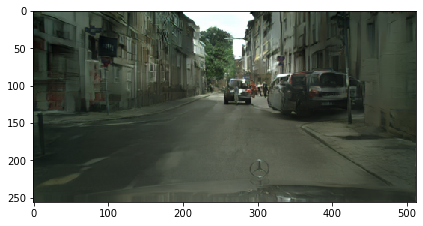

In [12]:
import numpy as np
from skimage import io
image = np.transpose(y[0].detach().cpu().numpy(), (1, 2, 0))
image -= image.min()
image /= image.max()
io.imshow(image)

In [13]:
generator.train(False)
generator.eval()
generator.to('cpu')
device = torch.device('cuda')
x = x.cpu()
z = z.cpu()
x = (x, z)
# import torch.onnx.symbolic_opset10 as onnx_symbolic
# def upsample_nearest2d(g, input, output_size, *args):
#     # Currently, TRT 5.1/6.0/7.0 ONNX Parser does not support all ONNX ops
#     # needed to support dynamic upsampling ONNX forumlation
#     # Here we hardcode scale=2 as a temporary workaround
#     scales = g.op("Constant", value_t=torch.tensor([1., 1., 2., 2.]))
#     return g.op("Resize", input, scales, mode_s="nearest")

# onnx_symbolic.upsample_nearest2d = upsample_nearest2d
torch.onnx.export(generator,
                  x,
                  "./gaugan.onnx",
                  export_params=True,
                  opset_version=10,
                  verbose=True
                 )

c:\users\james\stylegan2\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
c:\users\james\stylegan2\lib\site-packages\torch\onnx\symbolic_helper.py:198: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "


graph(%segmap : Float(1, 36, 256, 512),
      %input.1 : Float(1, 36, 4, 8),
      %fc.weight : Float(1024, 36, 3, 3),
      %fc.bias : Float(1024),
      %head_0.conv_0.bias : Float(1024),
      %head_0.conv_0.weight : Float(1024, 1024, 3, 3),
      %head_0.conv_1.bias : Float(1024),
      %head_0.conv_1.weight : Float(1024, 1024, 3, 3),
      %head_0.norm_0.param_free_norm.running_mean : Float(1024),
      %head_0.norm_0.param_free_norm.running_var : Float(1024),
      %head_0.norm_0.param_free_norm.num_batches_tracked : Long(),
      %head_0.norm_0.mlp_shared.0.weight : Float(128, 36, 3, 3),
      %head_0.norm_0.mlp_shared.0.bias : Float(128),
      %head_0.norm_0.mlp_gamma.weight : Float(1024, 128, 3, 3),
      %head_0.norm_0.mlp_gamma.bias : Float(1024),
      %head_0.norm_0.mlp_beta.weight : Float(1024, 128, 3, 3),
      %head_0.norm_0.mlp_beta.bias : Float(1024),
      %head_0.norm_1.param_free_norm.running_mean : Float(1024),
      %head_0.norm_1.param_free_norm.running_var : F

In [14]:
import onnx
onnx_model = onnx.load('./spade_generator_10.onnx')
onnx.checker.check_model(onnx_model)

In [15]:
import onnxruntime
import numpy as np
options = onnxruntime.SessionOptions()
options.log_severity_level = 0
options.log_verbosity_level = 4
onnx_session = onnxruntime.InferenceSession('./spade_generator_10.onnx', options)

In [16]:
in_name_1 = onnx_session.get_inputs()[0].name
in_name_2 = onnx_session.get_inputs()[1].name
from PIL import Image
from torchvision.transforms import transforms

image = Image.open('test_input.png')
image = image.resize((512, 256), Image.NEAREST)
transform_image = transforms.Compose([transforms.ToTensor()])
image = transform_image(image).unsqueeze(0) * 255.0
image = image.long()
image[image == 255] = 35
x = torch.FloatTensor(1, 35, 256, 512)
x = x.scatter_(1, image, 1.0).cpu()
image = Image.open('./instance_input.png')
image = image.resize((512, 256), Image.NEAREST)
t = transform_image(image).unsqueeze(0)
edge = torch.ByteTensor(t.size()).zero_()
edge[:, :, :, 1:] = edge[:, :, :, 1:] | (t[:, :, :, 1:] != t[:, :, :, :-1]).byte()
edge[:, :, :, :-1] = edge[:, :, :, :-1] | (t[:, :, :, 1:] != t[:, :, :, :-1]).byte()
edge[:, :, 1:, :] = edge[:, :, 1:, :] | (t[:, :, 1:, :] != t[:, :, :-1, :]).byte()
edge[:, :, :-1, :] = edge[:, :, :-1, :] | (t[:, :, 1:, :] != t[:, :, :-1, :]).byte()
edge = edge.float()
x = torch.cat((x, edge), dim=1)
z = torch.nn.functional.interpolate(x, size=(4, 8)).cpu().numpy()
x = x.cpu().numpy()

In [17]:
onnx_inputs = {in_name_1: x, in_name_2: z}
options = onnxruntime.RunOptions()
options.log_severity_level = 0
options.log_verbosity_level = 4
onnx_output = onnx_session.run(None, onnx_inputs, options)

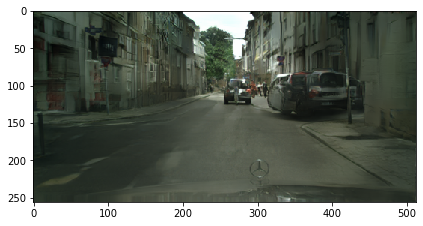

In [18]:
from skimage import io
onnx_output[0] -= onnx_output[0].min()
onnx_output[0] /= onnx_output[0].max()
io.imshow(np.transpose(onnx_output[0][0], (1, 2, 0)))